In [94]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

# Load some data

In [8]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [9]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [10]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [12]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(9.5)

In [144]:
data_with_fake_planet = add_fake_planets(
    input_stack=np.zeros_like(science_data),
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

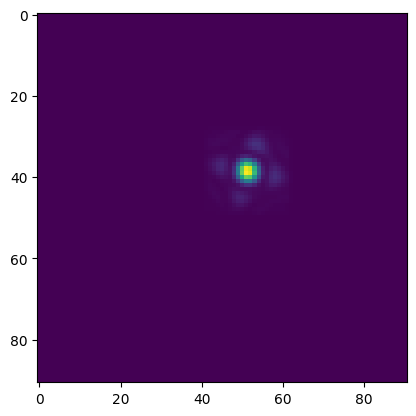

In [145]:
plt.imshow(data_with_fake_planet[0])

In [148]:
# pad the psf template
padded_psf = np.pad(
    psf_template, 
    pad_width=((35, 35), (35, 35)), 
    mode='constant', 
    constant_values=0)

In [495]:
# pynpoint fake planet routine
fake_planet_sequence_pynpoint = fake_planet(
    images=np.zeros_like(science_data),
    psf=padded_psf[np.newaxis, :, :],
    parang=np.rad2deg(angles),
    position=tuple(fake_planet_config["planet_position"][2:]),
    magnitude=9.5,
    psf_scaling=1.0 / (dit_psf_template / dit_science),
    interpolation='spline')

28.90760380681703


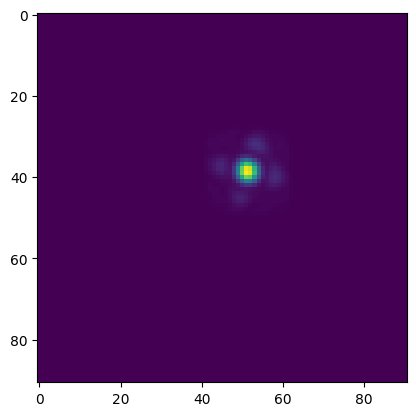

In [479]:
plt.imshow(fake_planet_sequence_pynpoint[0])
print(np.max(fake_planet_sequence_pynpoint[0]))

30.79126822620271


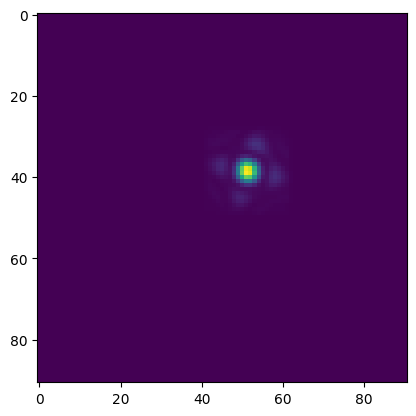

In [480]:
plt.imshow(data_with_fake_planet[0])
print(np.max(data_with_fake_planet[0]))

# The shift code of pynpoint

In [306]:
nd_factor = 1.0
sep = fake_planet_config["separation"]
ang = np.radians(fake_planet_config["planet_position"][-1] + 90 - np.rad2deg(angles))
flux_ratio = fake_planet_config["flux_ratio"]

integration_time_factor = dit_science / dit_psf_template * nd_factor

psf = padded_psf * flux_ratio * integration_time_factor

In [307]:
from pynpoint.util.image import shift_image

In [332]:
x_shift = sep*np.cos(ang)
y_shift = sep*np.sin(ang)
idx = 0

first_shifted_image = shift_image(
    psf,
    (float(y_shift[idx]), float(x_shift[idx])),
    "bilinear",#"spline",
    mode='reflect')

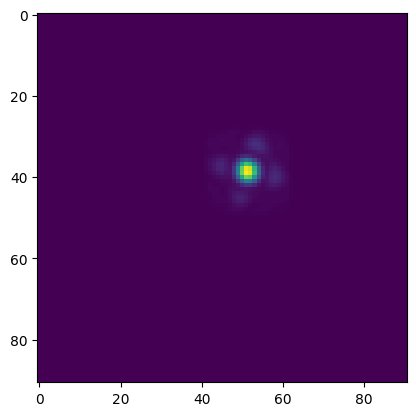

In [333]:
plt.imshow(first_shifted_image)

# the same in pytorch

In [334]:
import torch.nn.functional as F

In [414]:
ang = np.radians(fake_planet_config["planet_position"][-1] + 90 - np.rad2deg(angles))
ang_torch = torch.tensor(ang, dtype=torch.float32)

psf_torch = torch.tensor(padded_psf * flux_ratio * integration_time_factor,
                         dtype=torch.float32)

In [464]:
sep = fake_planet_config["separation"]
x_shift = sep * torch.cos(ang_torch)[0]
y_shift = sep * torch.sin(ang_torch)[0]

theta = torch.zeros(1, 2, 3)
theta[:, 0, 0] = 1
theta[:, 0, 1] = -0
theta[:, 1, 0] = 0
theta[:, 1, 1] = 1
theta[:, 0, 2] = - x_shift / (psf_torch.shape[0] - 1) * 2
theta[:, 1, 2] = - y_shift / (psf_torch.shape[1] - 1) * 2

grid = F.affine_grid(
    theta,
    torch.Size([1, 1, int(psf_torch.shape[0]), int(psf_torch.shape[1])]),
    align_corners=True)

In [465]:
shifted_data = F.grid_sample(
    psf_torch.unsqueeze(0).unsqueeze(0),
    grid,
    mode="bilinear",
    align_corners=True).squeeze()

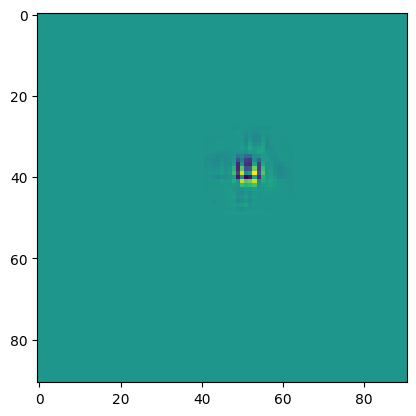

In [467]:
plt.imshow(first_shifted_image - shifted_data.numpy())

In [468]:
np.max(first_shifted_image - shifted_data.numpy())

2.609802335484801e-05

In [469]:
np.max(first_shifted_image)

28.90760380681703

In [470]:
np.max(shifted_data.numpy())

28.907606

# Implement the same for the whole sequence

In [521]:
device = "cpu"

pos_ang = fake_planet_config["planet_position"][-1]
sep = fake_planet_config["separation"]

ang = np.radians(pos_ang + 90 - np.rad2deg(angles))
ang_torch = torch.tensor(ang, dtype=torch.float32).to(device)

psf_torch = torch.tensor(
    padded_psf * flux_ratio * integration_time_factor,
    dtype=torch.float32).to(device)

x_shift = sep * torch.cos(ang_torch)
y_shift = sep * torch.sin(ang_torch)

In [522]:
for i in range(200):
    theta = torch.zeros(ang_torch.shape[0], 2, 3, device=device)
    theta[:, 0, 0] = 1
    theta[:, 1, 1] = 1
    theta[:, 0, 2] = - x_shift / (psf_torch.shape[0] - 1) * 2
    theta[:, 1, 2] = - y_shift / (psf_torch.shape[1] - 1) * 2
    
    grid = F.affine_grid(
        theta,
        torch.Size([ang_torch.shape[0], 1, int(psf_torch.shape[0]), int(psf_torch.shape[1])]),
        align_corners=True)
    
    shifted_data = F.grid_sample(
        psf_torch.unsqueeze(0).unsqueeze(0).repeat(ang_torch.shape[0], 1, 1, 1),
        grid,
        mode="bicubic",
        align_corners=True).squeeze()
    
shifted_data.cpu()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [523]:
shifted_data.device

device(type='cpu')

In [ ]:
# create a torch Size object
output_size = torch.Size([ang_torch.shape[0], 1, int(psf_torch.shape[0]), int(psf_torch.shape[1])])

In [502]:
shifted_data = F.grid_sample(
    psf_torch.unsqueeze(0).unsqueeze(0).repeat(ang_torch.shape[0], 1, 1, 1).to(0),
    grid,
    mode="bicubic",
    align_corners=True).squeeze().cpu()

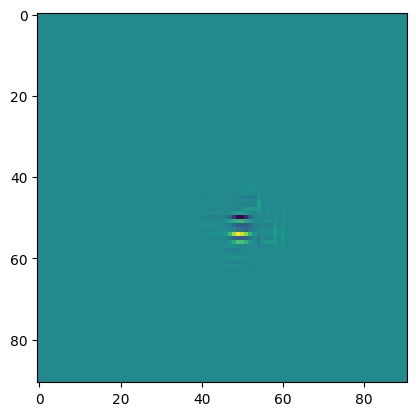

In [485]:
plt.imshow(shifted_data[-1].numpy() - fake_planet_sequence_pynpoint[-1])